In [1]:
import json
import pandas as pd
import numpy as np
import re
from pandas import *

#word clouds
import heapq
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import collections
import matplotlib.cm as cm
from matplotlib import rcParams
from tqdm import tqdm

#sentiment analysis
from textblob import TextBlob

#text preprocessing
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer 
nltk.download('stopwords')
nltk.download('wordnet')

#hide warning
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/crystal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/crystal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# spacy for lemmatization
import spacy; spacy.load('en')

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Extract information of Chipotle Mexican Grill from all Yelp restuarants

In [4]:
# convert json file into list
business = []
for line in open('business.json', 'r'):
    business.append(json.loads(line))

# convert list into dataframe
business = pd.DataFrame(business)

In [4]:
# convert json file into list
reviews = []
for line in open('review.json', 'r'):
    reviews.append(json.loads(line))

In [5]:
# convert list into dataframe
review = pd.DataFrame(reviews)

In [6]:
# remove useless columns and merge two tables
business_drop = business.drop(labels = {'address', 'postal_code', 'latitude', 'longitude', 'attributes', 'hours'}, axis = 1)
data_navie = pd.merge(business_drop, review, on="business_id", how="right")

In [7]:
# just keep information of Chipotle Mexican Grill
Chipotle = data_navie[data_navie['name']=='Chipotle Mexican Grill']
Chipotle.to_csv('Chipotle.csv')

# Exploratory Data Analysis

In [3]:
Chipotle = read_csv('Chipotle.csv')

#remove useless columns
Chipotle =Chipotle.drop(['Unnamed: 0', 'name', 'categories', 'user_id', 'review_id'], axis=1)

In [4]:
#separate into date, year, month, year_month and time
Chipotle['time']= Chipotle['date'].apply(lambda x: x.split()[1])
Chipotle['date']= Chipotle['date'].apply(lambda x: x.split()[0])
Chipotle['date'] = pd.to_datetime(Chipotle['date'])
Chipotle['year'] = Chipotle['date'].dt.to_period('Y')
Chipotle['month'] = Chipotle['date'].dt.month
Chipotle['year_month'] = Chipotle['date'].dt.to_period('M')

In [5]:
# most reviews are in range(2011-01-01, 2018-10-31), we will only show data in this period in some plots
len(Chipotle[(Chipotle['year']>= 2011) & (Chipotle['year_month']< '2018-11')])/len(Chipotle)

0.9412930135557873

In [6]:
Chipotle.head(2)

business_id       city state  stars_x  review_count  is_open  \
0  dusNIzdCaH6EoLl2hRy6cQ  Las Vegas    NV      3.5           115        1   
1  dusNIzdCaH6EoLl2hRy6cQ  Las Vegas    NV      3.5           115        1   

   stars_y  useful  funny  cool  \
0      1.0       1      0     0   
1      4.0       0      0     0   

                                                text       date      time  \
0  I'm a regular at chipotle in California, this ... 2016-07-25  05:07:18   
1  The food tasted the same as Chipotle back in m... 2012-09-10  15:44:21   

   year  month year_month  
0  2016      7    2016-07  
1  2012      9    2012-09

In [7]:
print("Number of Stores: ",len(Chipotle["business_id"].value_counts()))
print("Number of Opening Stores: ",len(Chipotle[Chipotle['is_open']==1]["business_id"].value_counts()))
print("Number of Reviews: ",len(Chipotle))
# We keep the information of stores that have been closed since they probably contain many "bad reviews"

Number of Stores:  183
Number of Opening Stores:  175
Number of Reviews:  9590


Text(0.5, 1.0, 'Change of Number of Reviews in Different Star Groups over Years')

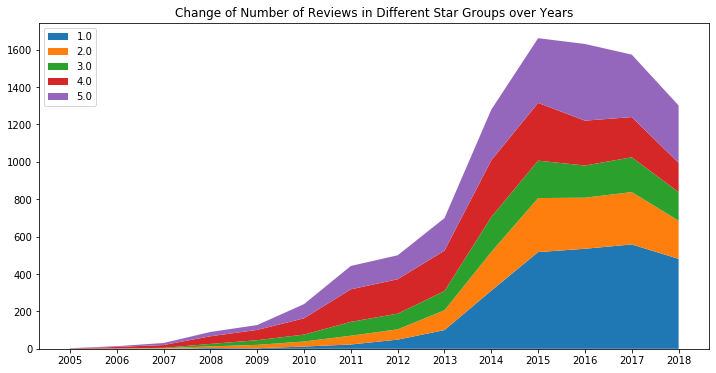

In [8]:
pivot = pd.pivot_table(Chipotle, index=['stars_y'],
                         columns=['year'],
                         values=['text'], 
                         aggfunc = lambda x: len(x), 
                         fill_value=0)

year_list = [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
fig= plt.figure(figsize = (12,6))
plt.stackplot(year_list, pivot.values, labels = pivot.index)
ax = plt.gca()
ax.set_xticks(year_list)
plt.legend(loc='upper left')
plt.title('Change of Number of Reviews in Different Star Groups over Years')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150]),
 <a list of 151 Text xticklabel objects>)

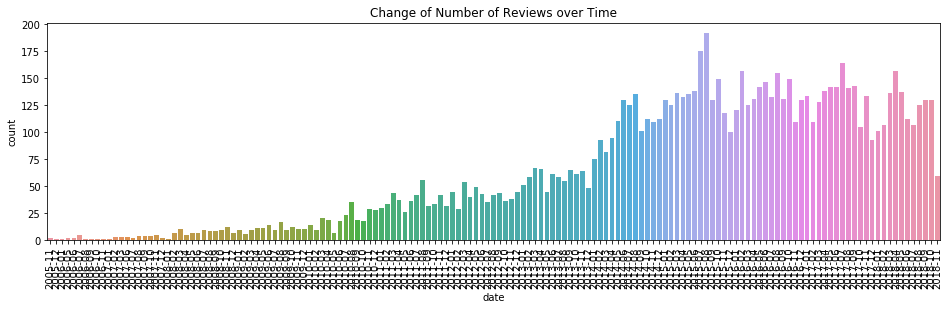

In [9]:
fig= plt.figure(figsize = (16,4))
sns.countplot(Chipotle['date'].dt.to_period('M'), order = np.unique(Chipotle['date'].dt.to_period('M')))
plt.title('Change of Number of Reviews over Time')
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

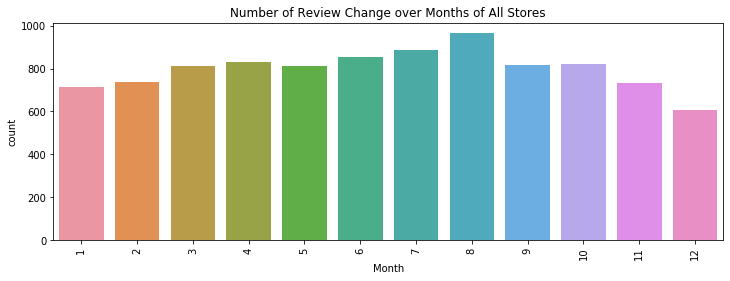

In [10]:
month = list(pd.DatetimeIndex(Chipotle['date']).month)
month.sort()
fig= plt.figure(figsize = (12,4))
sns.countplot(pd.DatetimeIndex(Chipotle['date']).month, order = np.unique(month))
plt.title('Number of Review Change over Months of All Stores')
plt.xlabel('Month')
plt.xticks(rotation = 90)

# Text Preprocessing

In [12]:
# review sample before preprocessing
Chipotle['text'][0]

"I'm a regular at chipotle in California, this is my first visit to this chipotle on s.las Vegas strip.this is pretty new place I think, I took a veggie bowl in which the rice was undone and the fajitas were all burnt, the quantity offered was less than usual. I'm very unhappy with this place."

In [13]:
#decontraction
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"o\'clock", "clock", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"that\'s", "that is", phrase)       
    phrase = re.sub(r"go-around", "go around", phrase)  
    # general
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    #phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [14]:
# return to words
Chipotle['review'] = Chipotle['text'].apply(lambda x: decontracted(x))

# to lower
Chipotle['review'] = Chipotle['review'].apply(lambda x: x.lower())

# remove stop words

stop_words = set(stopwords.words('english'))
not_stopwords = {'no','nor','not'} 
final_stop_words = set([word for word in stop_words if word not in not_stopwords])
# stop_words = stopwords.words('english')
Chipotle['review'] = Chipotle['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in final_stop_words]))

# remove non-word and punctuations
rm_punc = re.compile(r"\W")
shrink_spaces = re.compile(r"\s+")
Chipotle['review'] = Chipotle['review'].apply(lambda x: rm_punc.sub(' ', x))
Chipotle['review'] = Chipotle['review'].apply(lambda x: shrink_spaces.sub(' ', x))

In [15]:
# lemmantize
lemmatizer = WordNetLemmatizer() 
Chipotle['review'] = Chipotle['review'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))

In [16]:
# review sample after preprocessing
Chipotle['review'].iloc[0]

'regular chipotle california first visit chipotle s la vega strip this pretty new place think took veggie bowl rice undone fajitas burnt quantity offered le usual unhappy place'

# Sentiment Analysis

In [17]:
# get polarity using sentiment analysis
Chipotle['sentiment_socre'] = Chipotle['review'].map(lambda text: TextBlob(text).sentiment.polarity)

#classify sentiment into positive and negative ones
Chipotle['sentiment'] = ''
Chipotle['sentiment'][Chipotle['sentiment_socre'] > 0] = 'positive'
Chipotle['sentiment'][Chipotle['sentiment_socre'] <= 0] = 'negative'

/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Review Sentiments Distrubition')

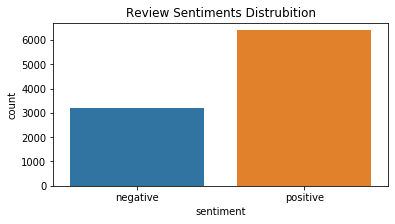

In [18]:
plt.figure(figsize=(6,3))
ax = sns.countplot(Chipotle['sentiment'])
plt.title('Review Sentiments Distrubition')

Text(0.5, 1.0, 'Review Sentiments Distrubition in Different Star Groups')

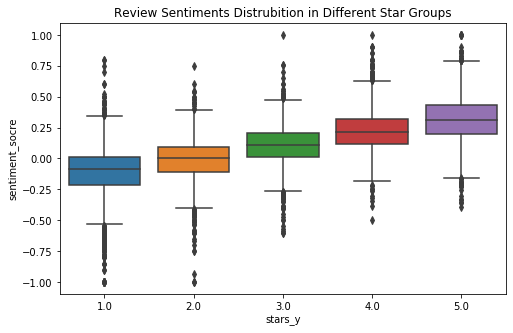

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(x ='stars_y',y='sentiment_socre',data = Chipotle)
plt.title('Review Sentiments Distrubition in Different Star Groups')

# Word Clouds

In [25]:
# Create word frequency count
word2count = {}
for i in tqdm(range(len(Chipotle['review']))): 
    for word in Chipotle['review'].iloc[i].split():
        if word not in word2count.keys(): 
            word2count[word] = 1
        else: 
            word2count[word] += 1

100%|██████████| 9590/9590 [00:00<00:00, 28490.78it/s]


In [26]:
# Show the most frequent 200 words
freq_words = heapq.nlargest(200, word2count, key=word2count.get)
# print(freq_words)

In [32]:
# Remove meaningless words
a = ['1','2','3','4','5','6','7','8','9','10','one','two']
b = ['n','s','m','i']
c = ['it','in','ve','well','could','would','really','also','even','alway','always','still','never']
# meaningless verbs
d = ['said','asked','did','love','go','got','do','make','know','eat']
# nouns that appear so frequently that makes the comparison of two word clouds meaningless
e = ['chipotle','food','burrito','bowl','location','place','time','order']
# meaningless adjectives
f = ['good','great']
add_stopwords = a+b+c+d+e+f

# Add meaningless words into stopwords
for i in range(len(add_stopwords)):
    STOPWORDS.add(add_stopwords[i])

In [33]:
def wordcloud_draw(x, y):
    wordcloud = WordCloud(width=1600, height=800, random_state=1, max_words=200, background_color='white', stopwords=set(STOPWORDS))
    wordcloud.generate(str(set(x['review'])))
    # declare our figure 
    plt.figure(figsize=(15,8))
    plt.title(y, fontsize=40,color='Red')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=10)
    plt.show()

In [34]:
Chipotle_pos = pd.DataFrame(Chipotle['review'][Chipotle['sentiment'] == 'positive'])
Chipotle_neg = pd.DataFrame(Chipotle['review'][Chipotle['sentiment'] == 'negative'])

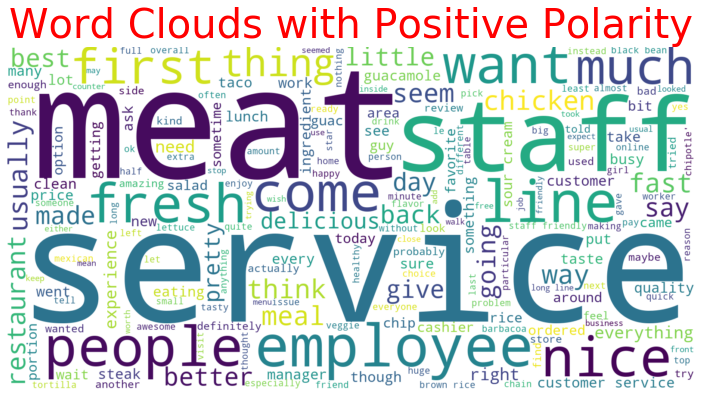

In [35]:
wordcloud_draw(Chipotle_pos, "Word Clouds with Positive Polarity")

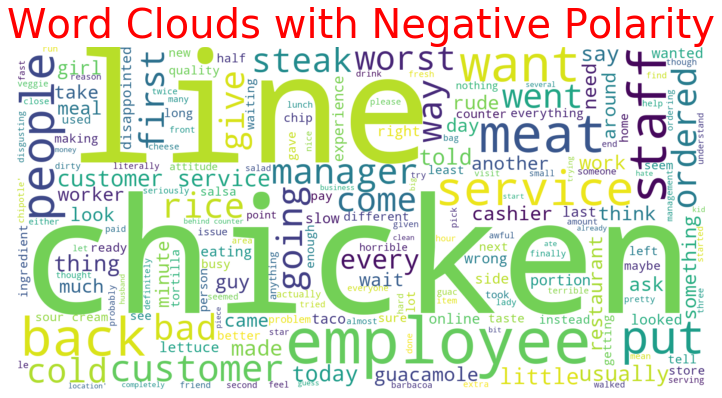

In [36]:
wordcloud_draw(Chipotle_neg, "Word Clouds with Negative Polarity")

# Topic Modeling

## Text Preprocessing

In [70]:
# tokenize each sentence into a list of words, removing punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(Chipotle['review']))

In [71]:
#Lemmatization
wnl = WordNetLemmatizer()
data_words = [[wnl.lemmatize(word) for word in sentence] for sentence in data_words]

In [72]:
# Remove Stop and common Words
stopwords = nltk.corpus.stopwords.words('english')

newStopWords =  ['no','nor','not','n','s','m','i',
                '1','2','3','4','5','6','7','8','9','10','one','two',
                 'it','in','ve','well','could','would','really','also','even',
                 'alway','always','still','never','much','thing','yet',
                 'said','asked','did','go','got','do','make','know','think','come','going',
                 'put','went','seem','ordered','give','eat','make','get','chipotle','guy']
stopwords.extend(newStopWords)

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

data_words = remove_stopwords(data_words)

In [73]:
#create bag-of-words for each narrative
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])
# print(bigram_mod[data_words[0]])

In [74]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [75]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# print(data_lemmatized[:1])

In [76]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
# print(corpus[:1])

## Finding the optimal number of topics using LdaMallet model

In [77]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,random_seed=101)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [78]:
# Can take a long time to run.
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=12, step=1)

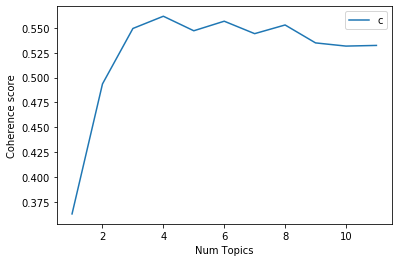

In [79]:
# Show graph
limit=12; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [80]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.3629
Num Topics = 2  has Coherence Value of 0.4936
Num Topics = 3  has Coherence Value of 0.5493
Num Topics = 4  has Coherence Value of 0.5616
Num Topics = 5  has Coherence Value of 0.547
Num Topics = 6  has Coherence Value of 0.5566
Num Topics = 7  has Coherence Value of 0.5441
Num Topics = 8  has Coherence Value of 0.5528
Num Topics = 9  has Coherence Value of 0.5348
Num Topics = 10  has Coherence Value of 0.5316
Num Topics = 11  has Coherence Value of 0.5323


Topic Coherence is a measure used to evaluate topic models: it  is applied to the top N words from the topic. It is defined as the average / median of the pairwise word-similarity scores of the words in the topic.
A good model will generate coherent topics and can be described by a short label, therefore this is what the topic coherence measure should capture.

Perplexity: Perplexity is a measurement of how well a probability model predicts a test data.
Low perplexity is good and high perplexity is bad since the perplexity is the exponentiation of the entropy (a measure of uncertainty or randomness).

## Finding Key Words for each topic  using optimal LdaMallet model

In [170]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.114*"time" + 0.097*"order" + 0.085*"line" + 0.044*"wait" + 0.042*"people" '
  '+ 0.028*"minute" + 0.027*"long" + 0.022*"online" + 0.016*"food" + '
  '0.015*"pick"'),
 (1,
  '0.049*"location" + 0.041*"staff" + 0.030*"lunch" + 0.030*"place" + '
  '0.029*"portion" + 0.028*"clean" + 0.027*"pretty" + 0.026*"good" + '
  '0.025*"nice" + 0.024*"friendly"'),
 (2,
  '0.039*"meat" + 0.037*"chicken" + 0.031*"bowl" + 0.027*"chip" + 0.026*"rice" '
  '+ 0.024*"guacamole" + 0.023*"extra" + 0.023*"steak" + 0.018*"serve" + '
  '0.017*"lettuce"'),
 (3,
  '0.115*"food" + 0.058*"good" + 0.051*"love" + 0.047*"great" + 0.040*"place" '
  '+ 0.039*"fast" + 0.033*"fresh" + 0.019*"ingredient" + 0.017*"quality" + '
  '0.016*"meal"'),
 (4,
  '0.069*"service" + 0.056*"location" + 0.049*"customer" + 0.044*"employee" + '
  '0.041*"bad" + 0.030*"experience" + 0.027*"work" + 0.024*"food" + '
  '0.015*"day" + 0.013*"visit"'),
 (5,
  '0.032*"back" + 0.023*"give" + 0.022*"pay" + 0.021*"manager" + 0.020*"make" '


- 0: time/line/wait/long
- 1: location/clean/nice/friendly
- 2: meat/chicken/chip/rice/guacamole/steak/lettuce
- 3: fresh/ingredient/quality
- 4: service/employee/bad
- 5: pay/manager/cashier

## Determing the dominant topic in each review

In [141]:
sent_topics_df = pd.DataFrame()
for i, row in enumerate(optimal_model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = optimal_model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)

In [142]:
sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
df_dominant_topic = pd.concat([sent_topics_df, Chipotle], axis=1)
df_dominant_topic['year_month'] = df_dominant_topic['date'].dt.to_period('M')

# Show
df_dominant_topic.head(2)

Dominant_Topic  Perc_Contribution  \
0             2.0             0.2359   
1             1.0             0.2877   

                                      Topic_Keywords             business_id  \
0  meat, chicken, bowl, chip, rice, guacamole, ex...  dusNIzdCaH6EoLl2hRy6cQ   
1  location, staff, lunch, place, portion, clean,...  dusNIzdCaH6EoLl2hRy6cQ   

        city state  stars_x  review_count  is_open  stars_y  ...  cool  \
0  Las Vegas    NV      3.5           115        1      1.0  ...     0   
1  Las Vegas    NV      3.5           115        1      4.0  ...     0   

                                                text       date      time  \
0  I'm a regular at chipotle in California, this ... 2016-07-25  05:07:18   
1  The food tasted the same as Chipotle back in m... 2012-09-10  15:44:21   

   year month year_month                                             review  \
0  2016     7    2016-07  regular chipotle california first visit chipot...   
1  2012     9    2012-09  food tasted chipotle back home state consisten...   

  sentiment_socre sentiment  
0       -0.035606  negative  
1        0.189220  positive  

[2 rows x 22 columns]

# Combining Topic Modeling and Sentiment Analysis

## Find the average star in each topic

In [171]:
radar_list = df_dominant_topic.groupby(['Dominant_Topic'])['sentiment_socre'].mean()
topic_list =['time/line/wait/long/online','location/clean/nice/friendly','meat/chicken/chip/rice/guacamole/steak',
           'fresh/ingredient/quality', 'service/employee/bad','pay/manager/cashier']

radar_list

Dominant_Topic
0.0    0.035655
1.0    0.181740
2.0    0.014019
3.0    0.284053
4.0    0.008642
5.0    0.021478
Name: sentiment_socre, dtype: float64

In [172]:
#Radar Chart of Scores in Different Topics
radar_list =radar_list.apply(lambda x : x+0.1)

df = pd.DataFrame(dict(
    r=radar_list,
    theta=topic_list))
fig = px.line_polar(df, r='r', theta='theta', line_close=True,start_angle=90)
fig.show()

## Find the sentiment change in each topic over time

In [160]:
# just keep the rows from 2011.01 to 2018.10
df_dominant_topic = df_dominant_topic[(df_dominant_topic['year']>= 2011) & (df_dominant_topic['year_month']< '2018-11')]

In [161]:
pivot = pd.pivot_table(df_dominant_topic, index=['Dominant_Topic'],
                         columns=['year_month'],
                         values=['sentiment_socre'], 
                         aggfunc = np.mean, 
                         fill_value=0)

In [180]:
year_month_list = ['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', 
 '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11', '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08', '2013-09', 
 '2013-10', '2013-11', '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08', '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', 
 '2015-02', '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02', '2016-03', '2016-04', '2016-05', 
 '2016-06', '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08', '2017-09', 
 '2017-10', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10']

even_year_month_list= [] 
for i in range(0, len(year_month_list)): 
    if i % 2: 
        even_year_month_list.append(year_month_list[i]) 

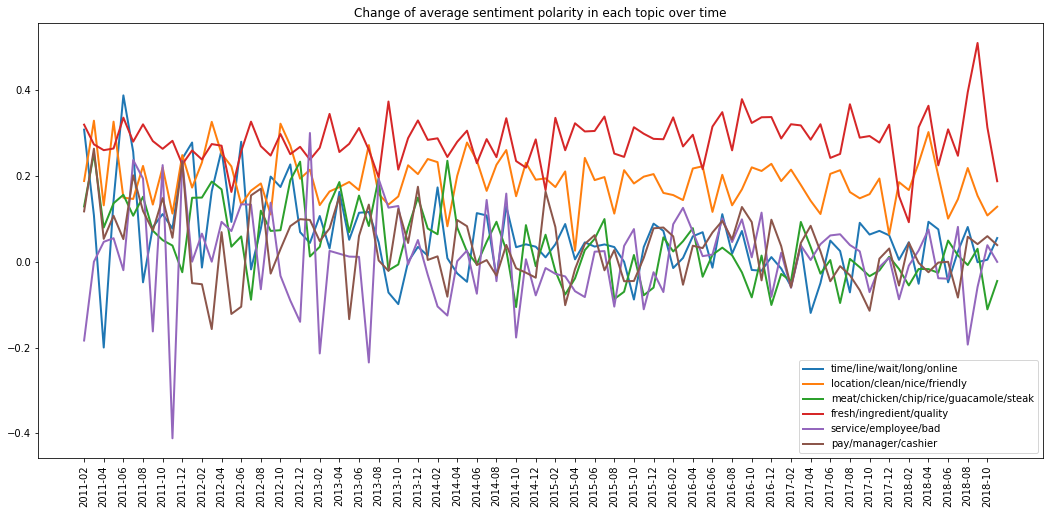

In [181]:
plt.figure(figsize=(18,8))
plt.plot(pivot.values[0], linewidth=2,label=topic_list[0])
plt.plot(pivot.values[1], linewidth=2,label=topic_list[1])
plt.plot(pivot.values[2], linewidth=2,label=topic_list[2])
plt.plot(pivot.values[3], linewidth=2,label=topic_list[3])
plt.plot(pivot.values[4], linewidth=2,label=topic_list[4])
plt.plot(pivot.values[5], linewidth=2,label=topic_list[5])
plt.xticks(np.arange(0, 94, 2.0))
locs, labels=plt.xticks()
x_ticks = list(np.arange(0, 94, 2.0))
new_xticks= even_year_month_list 
plt.xticks(locs,new_xticks, rotation=90)
plt.title('Change of average sentiment polarity in each topic over time')
plt.legend()

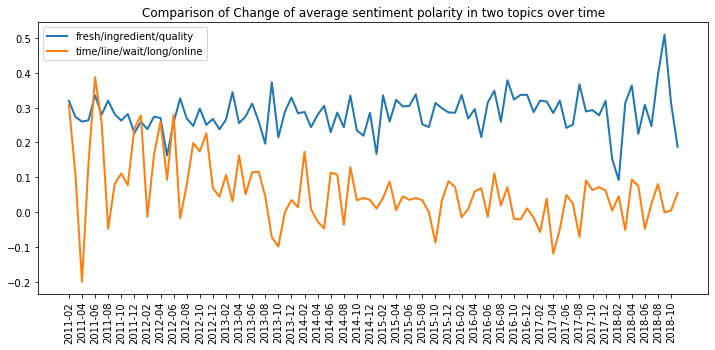

In [178]:
plt.figure(figsize=(12,5))
plt.plot(pivot.values[3], linewidth=2,label=topic_list[3])
plt.plot(pivot.values[0], linewidth=2,label=topic_list[0])
plt.xticks(np.arange(0, 94, 2.0))
locs, labels=plt.xticks()
x_ticks = list(np.arange(0, 94, 2.0))
new_xticks= even_year_month_list
plt.title('Comparison of Change of average sentiment polarity in two topics over time')
plt.xticks(locs,new_xticks, rotation=90)
plt.legend()

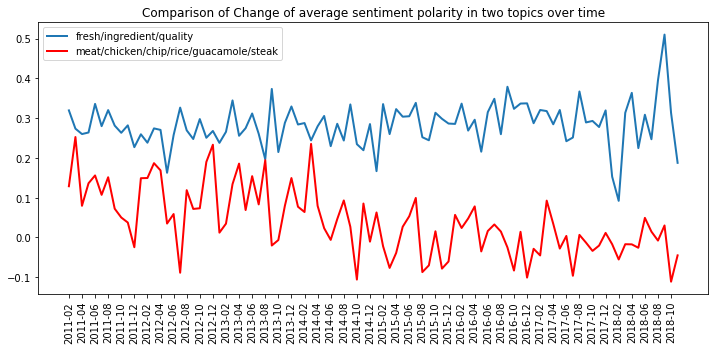

In [177]:
plt.figure(figsize=(12,5))
# plt.plot(pivot.values[0], linewidth=2,label='time/line/wait/long')
plt.plot(pivot.values[3], linewidth=2,label=topic_list[3])
plt.plot(pivot.values[2], linewidth=2,label=topic_list[2],color = 'r')
plt.xticks(np.arange(0, 94, 2.0))
locs, labels=plt.xticks()
x_ticks = list(np.arange(0, 94, 2.0))
new_xticks= even_year_month_list 
plt.title('Comparison of Change of average sentiment polarity in two topics over time')
plt.xticks(locs,new_xticks, rotation=90)
plt.legend()

# Time Series Sentiment Analysis

## Collect Reviews and Count Words

In [20]:
review_list_ch = Chipotle['review'].tolist()
review_all_ch = ' '.join(review_list_ch)
word_list_ch = [word for word in review_all_ch.lower().split() if word not in STOPWORDS]
counted_words = collections.Counter(word_list_ch)
words = []
counts = []
for letter, count in counted_words.most_common(50):
    words.append(letter)
    counts.append(count)

## Calculate Word Occurence Ratio in Positive / Negative Reviews

In [21]:
pcount = []
ncount = []
for word in words:
    pcount.append(sum(Chipotle[Chipotle['sentiment'] == "positive"]["text"].str.contains(word)))
    ncount.append(sum(Chipotle[Chipotle['sentiment'] == "negative"]["text"].str.contains(word)))

In [22]:
pcount_normalized = np.asarray(pcount)/Chipotle.loc[Chipotle['sentiment'] == "positive"].shape[0]
ncount_normalized = np.asarray(ncount)/Chipotle.loc[Chipotle['sentiment'] == "negative"].shape[0]

In [23]:
word_pos_neg_cnt_df = pd.DataFrame({'positive ratio': pcount_normalized, 'negative ratio': ncount_normalized}, index=words)
word_pos_neg_cnt_df.head()

positive ratio  negative ratio
chipotle        0.171312        0.250624
food            0.505168        0.415418
location        0.365800        0.372347
burrito         0.295803        0.250624
time            0.364234        0.392634

## Preliminary Analysis

### Stars vs Month

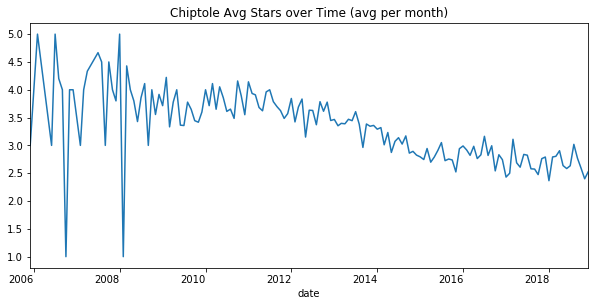

In [24]:
df_ch_star = Chipotle[['stars_y', 'date']]
ch_star_monthly_change = df_ch_star.set_index('date').resample('M').stars_y.mean()
ch_star_monthly_change = ch_star_monthly_change.dropna()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ch_star_monthly_change.plot.line(label='Stars', ax=ax, rot=0, figsize=(10, 5), title="Chiptole Avg Stars over Time (avg per month)")

### Total positive / negative reviews per month

In [25]:
# monthly total positive rows
Chipotle_pos_cnt = Chipotle.set_index('date').groupby('sentiment').get_group('positive').resample('M').count().sentiment
Chipotle_neg_cnt = Chipotle.set_index('date').groupby('sentiment').get_group('negative').resample('M').count().sentiment

/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 65295 missing from current font.

/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning:

Glyph 65295 missing from current font.



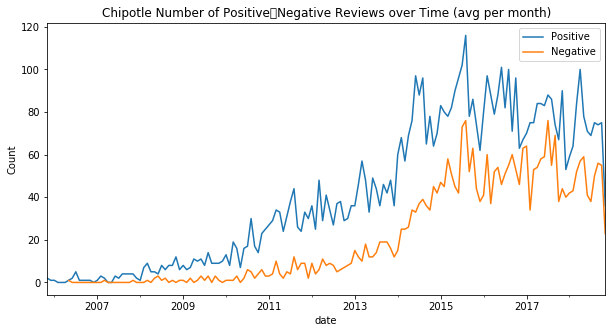

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
Chipotle_pos_cnt.plot.line(label='Positive', ax=ax, rot=0, figsize=(10, 5), style='-')
Chipotle_neg_cnt.plot.line(label='Negative', ax=ax, rot=0, figsize=(10, 5), style='-')
plt.ylabel('Count')
plt.title("Chipotle Number of Positive／Negative Reviews over Time (avg per month)")
plt.legend()

## Occurence of top frequent word in positive / negative reviews per month: step by step

### All reviews containing keyword

In [27]:
# current woi (word of interest)
idx = 1
words[idx]
woi = words[1]
Chipotle_woi = Chipotle.loc[Chipotle['text'].str.contains(woi)]
Chipotle_woi.head(2)

business_id       city state  stars_x  review_count  is_open  \
1  dusNIzdCaH6EoLl2hRy6cQ  Las Vegas    NV      3.5           115        1   
2  dusNIzdCaH6EoLl2hRy6cQ  Las Vegas    NV      3.5           115        1   

   stars_y  useful  funny  cool  \
1      4.0       0      0     0   
2      1.0      10      8     9   

                                                text       date      time  \
1  The food tasted the same as Chipotle back in m... 2012-09-10  15:44:21   
2  This is seriously the WORST chipotle I have ev... 2017-05-13  11:25:44   

   year  month year_month                                             review  \
1  2012      9    2012-09  food tasted chipotle back home state consisten...   
2  2017      5    2017-05  seriously worst chipotle ever coming year must...   

   sentiment_socre sentiment  
1         0.189220  positive  
2        -0.013686  negative

### Positive / negative reviews containing keyword

In [28]:
Chipotle_woi_pos_cnt = Chipotle_woi.set_index('date').groupby('sentiment').get_group('positive').resample('M').count().sentiment
Chipotle_woi_neg_cnt = Chipotle_woi.set_index('date').groupby('sentiment').get_group('negative').resample('M').count().sentiment

### Occurence ratio in positive and negative reviews and plot

Text(0.5, 1.0, 'Monthly percentage of service in positive/negative reviews')

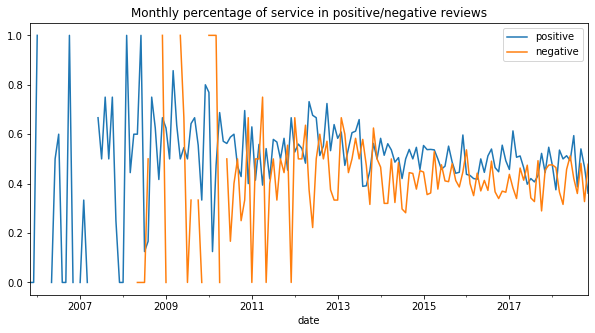

In [29]:
woi = 'service'
Chipotle_woi_pos_ratio = Chipotle_woi_pos_cnt.divide(Chipotle_pos_cnt, fill_value=0.0)
Chipotle_woi_pos_ratio.plot.line(rot=0, figsize=(10, 5),label = 'positive')
Chipotle_woi_neg_ratio = Chipotle_woi_neg_cnt.divide(Chipotle_neg_cnt, fill_value=0.0)
Chipotle_woi_neg_ratio.plot.line(rot=0,label = 'negative')
plt.legend()
plt.title("Monthly percentage of {} in positive/negative reviews".format(woi))

# Examine All Frequent Words

In [30]:
def GetStarsInDateRange(x, start, end, colname):
    x_df = x.to_frame().reset_index('date')
    return x_df.loc[(x_df['date'] >= start) & (x_df['date'] <= end)].set_index('date')[colname]

/Users/crystal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



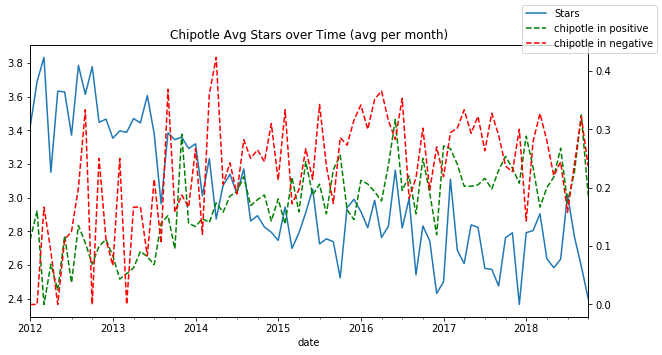

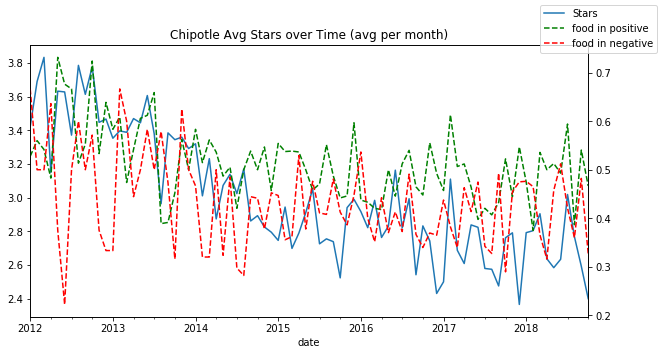

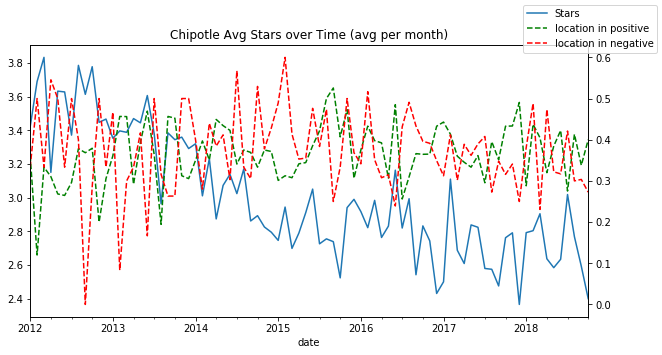

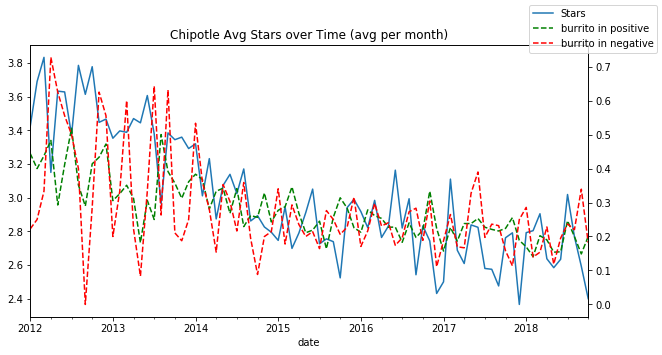

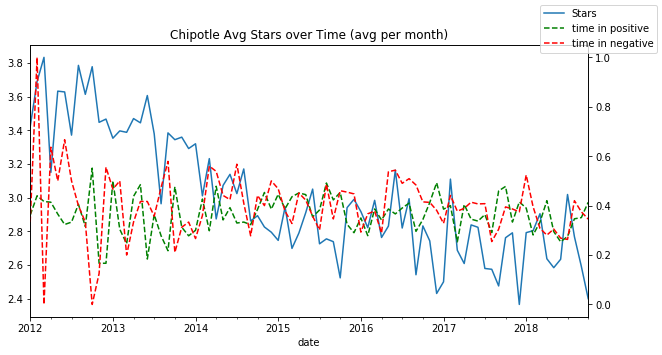

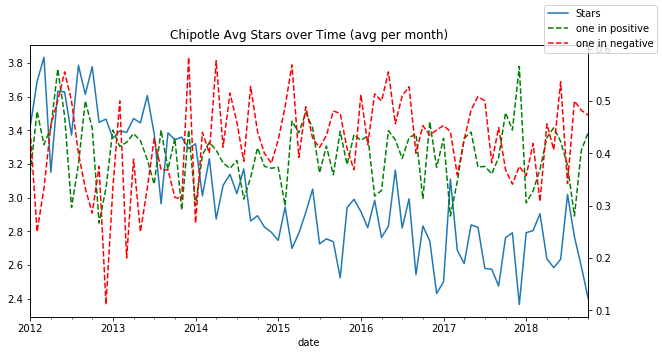

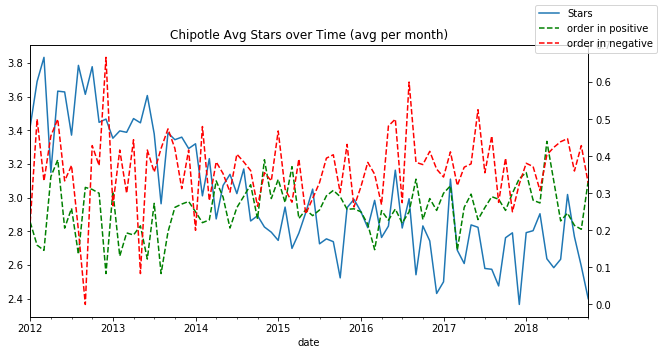

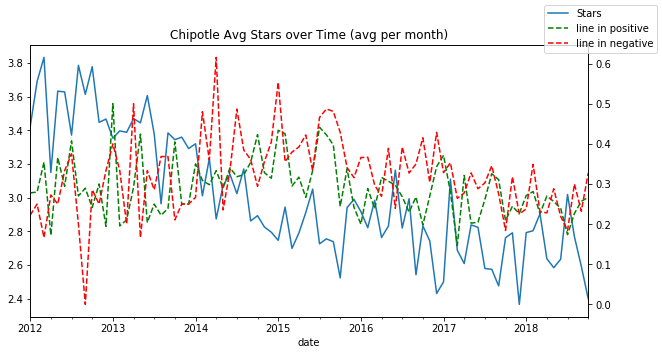

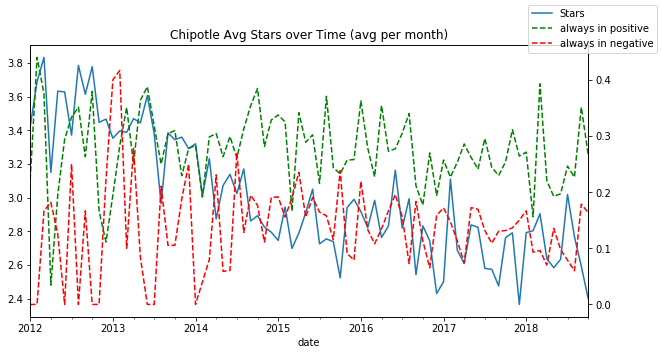

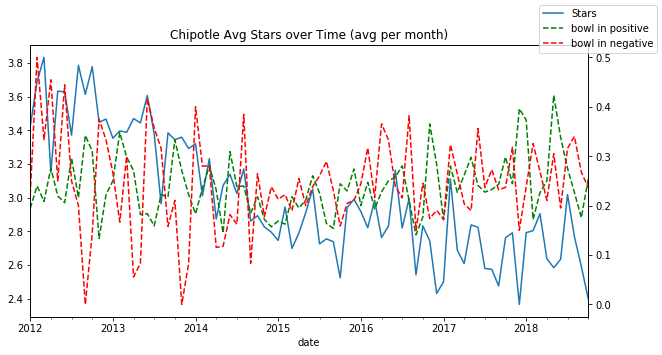

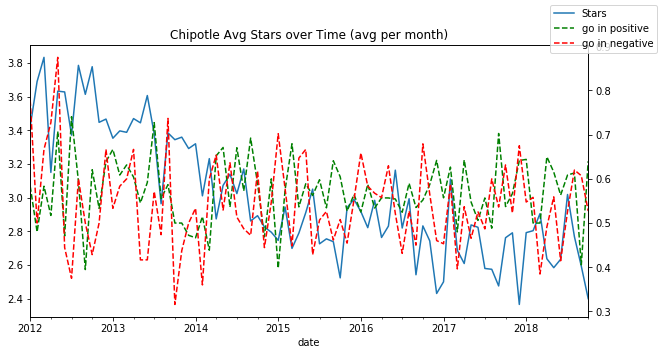

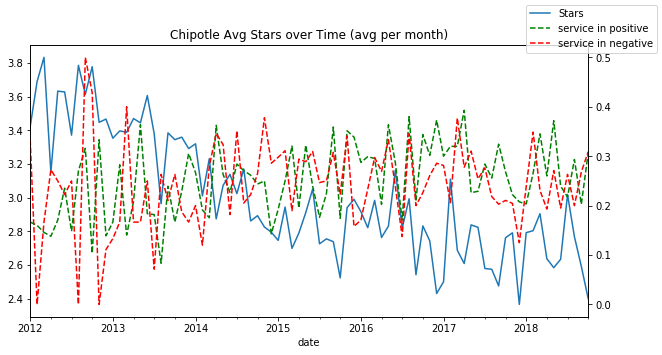

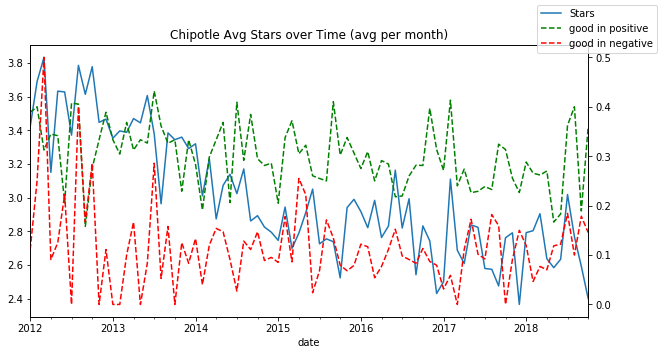

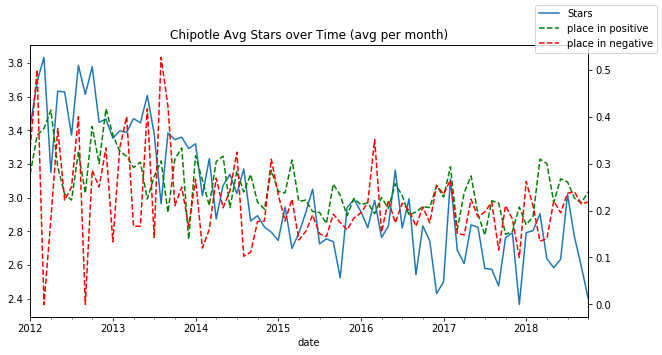

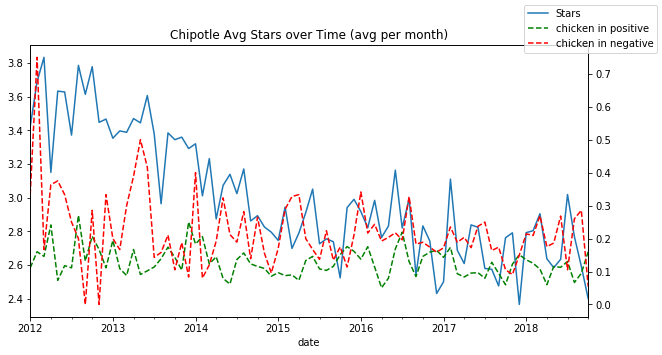

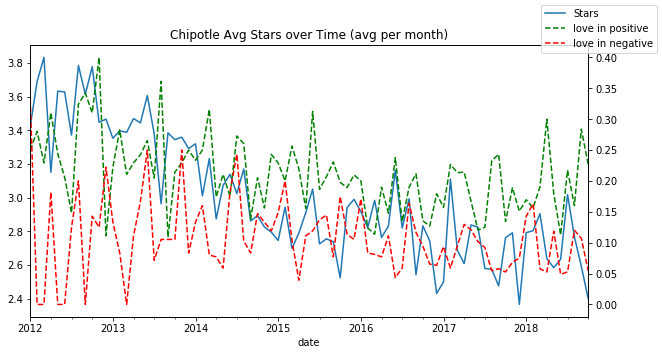

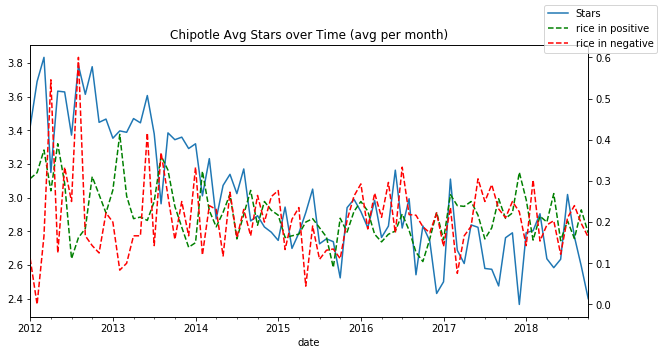

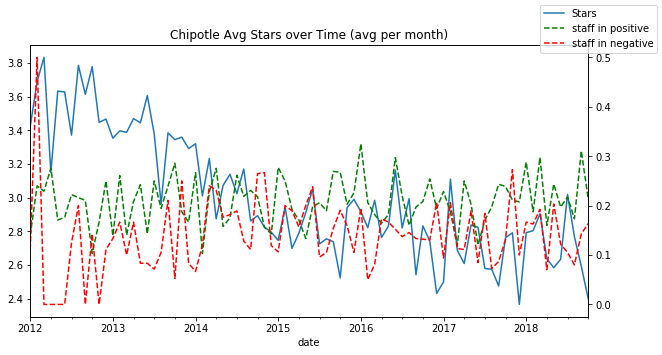

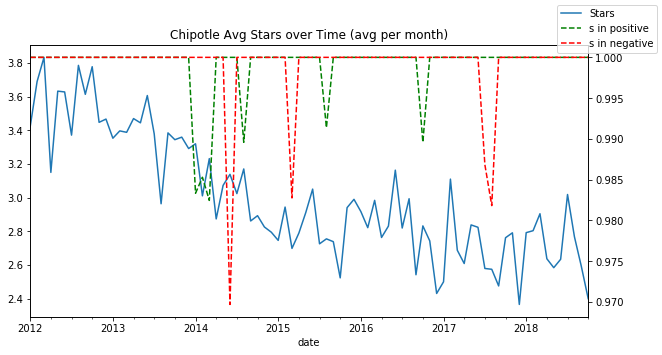

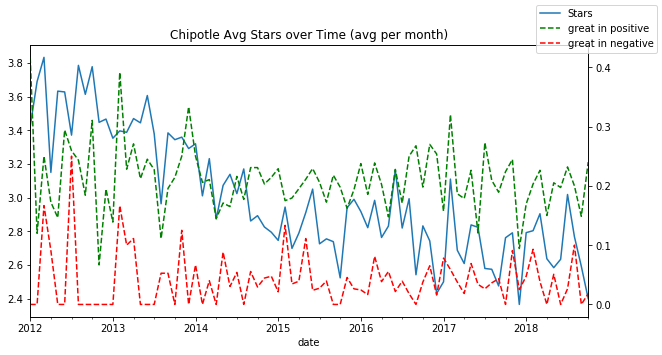

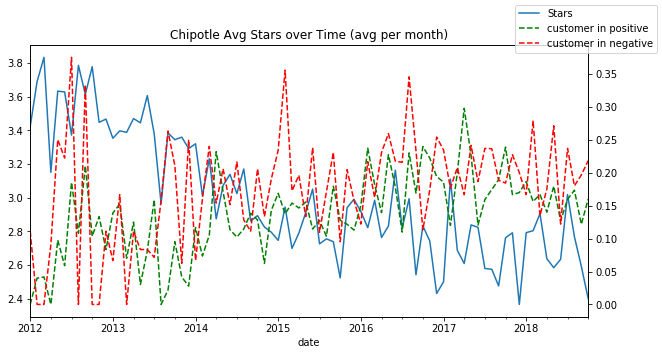

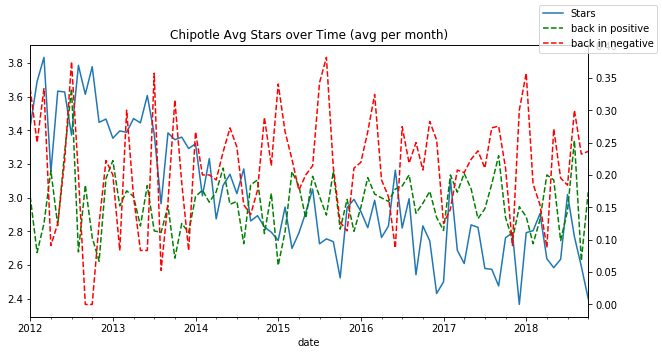

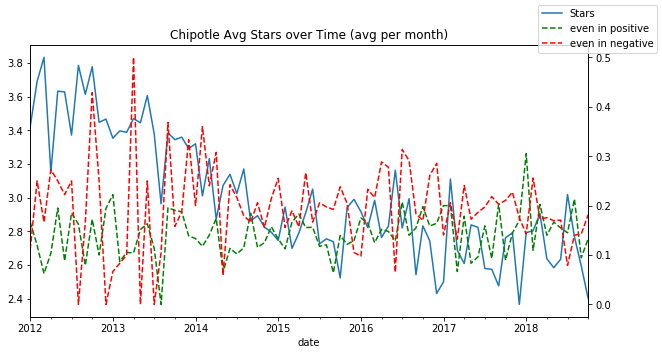

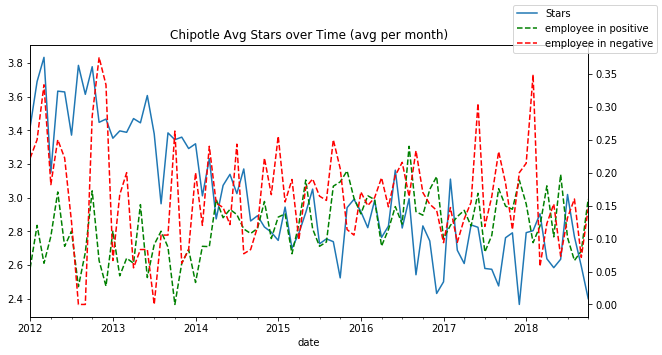

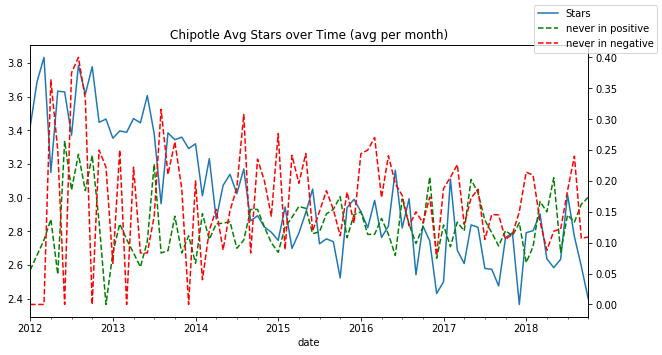

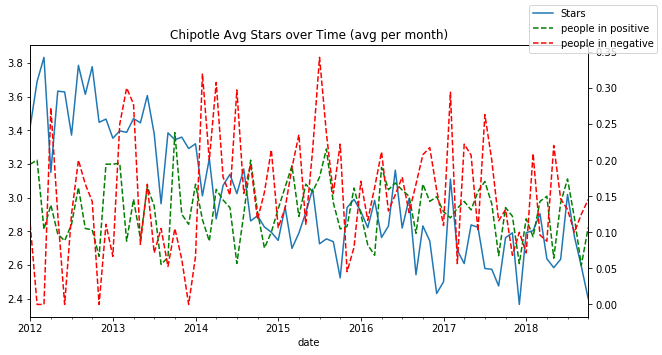

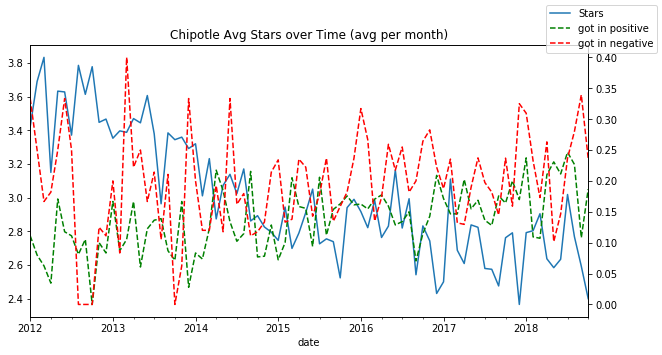

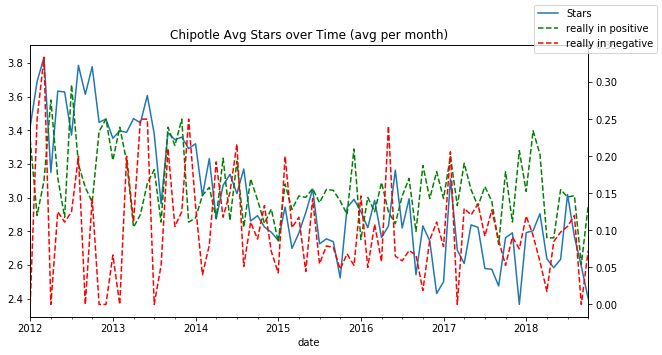

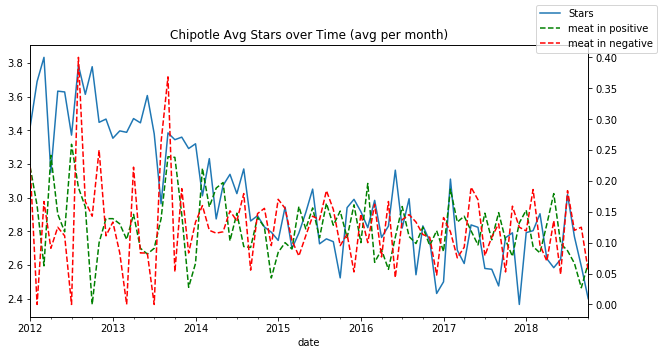

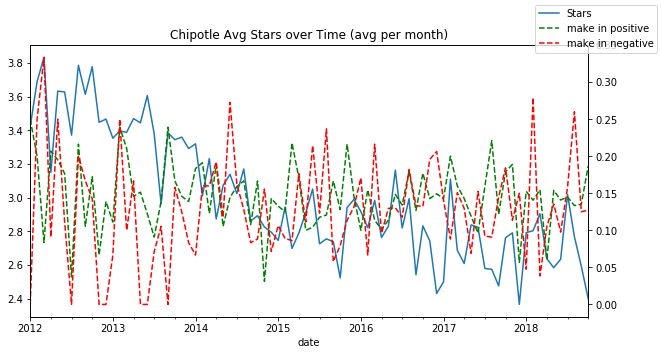

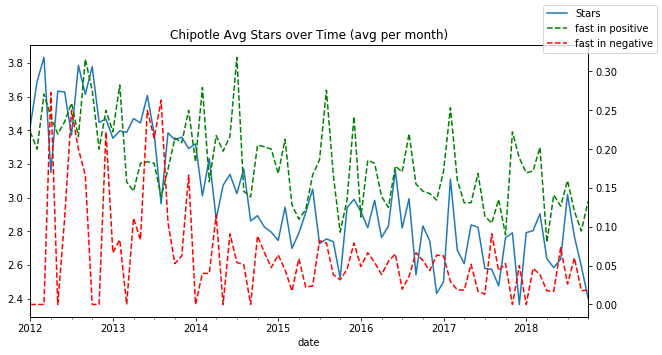

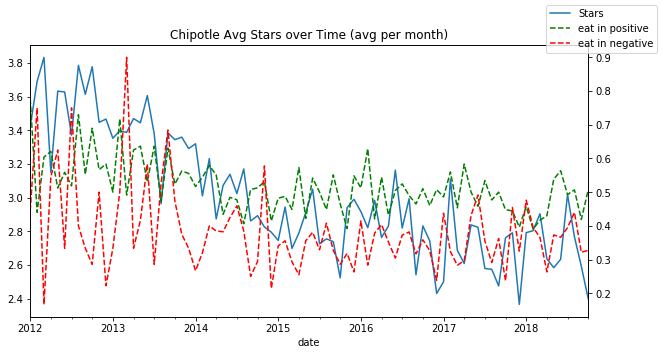

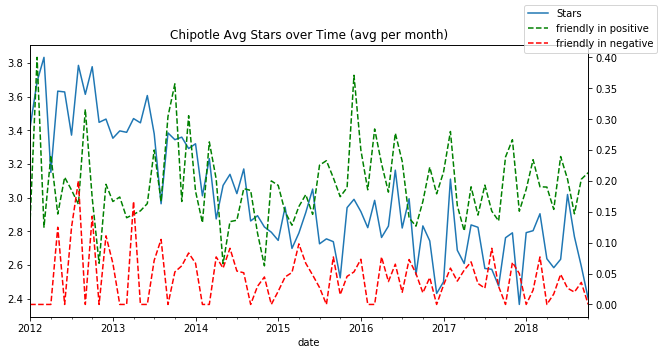

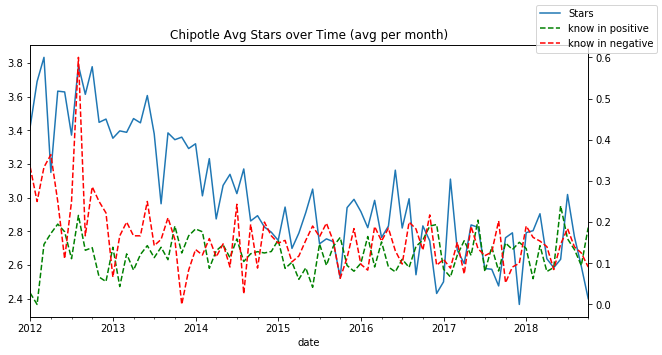

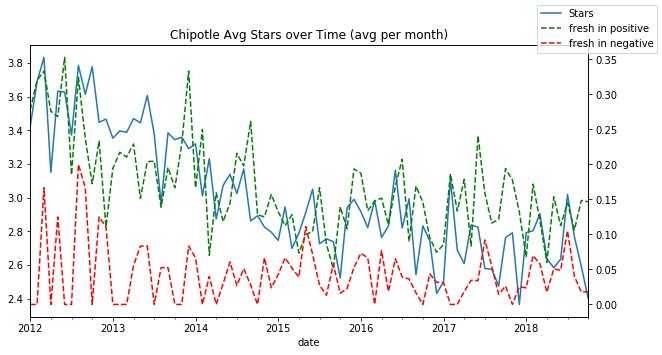

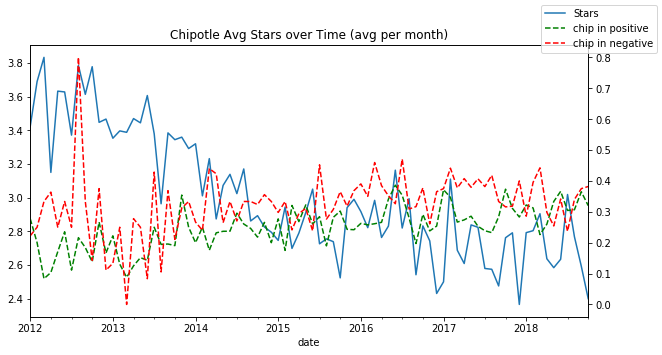

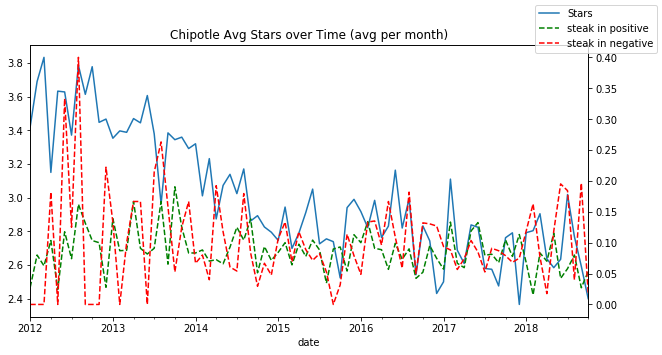

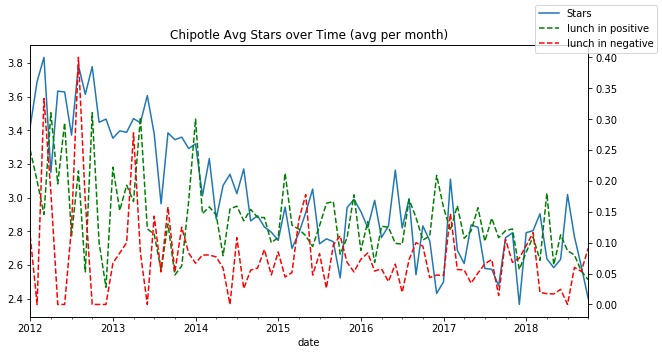

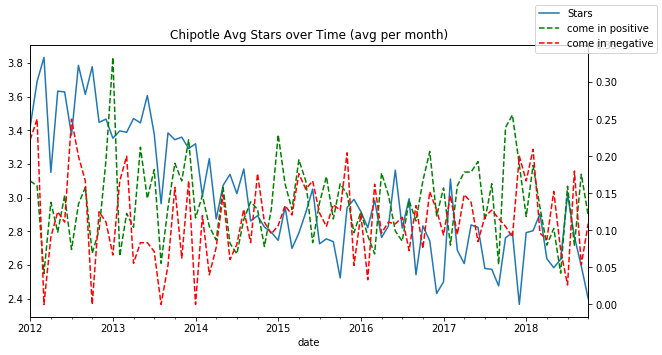

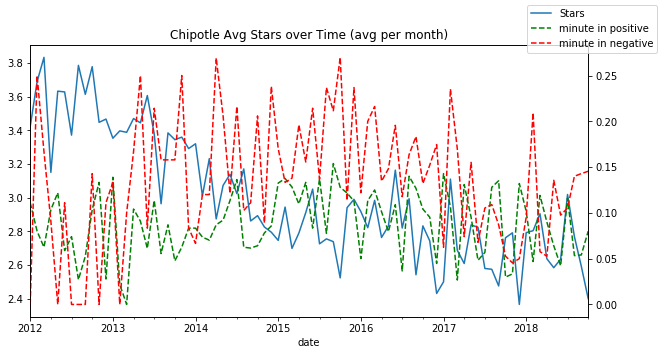

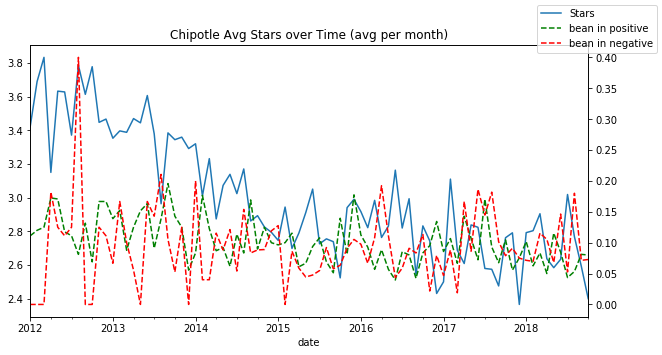

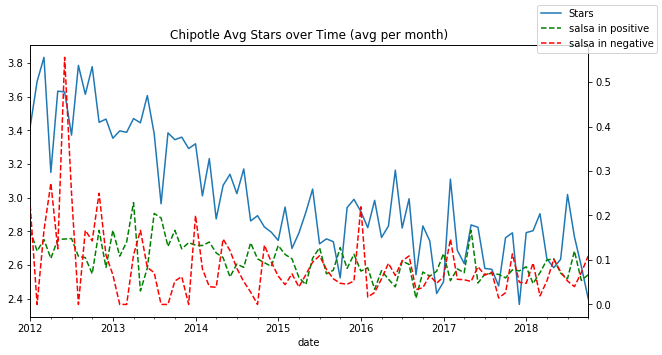

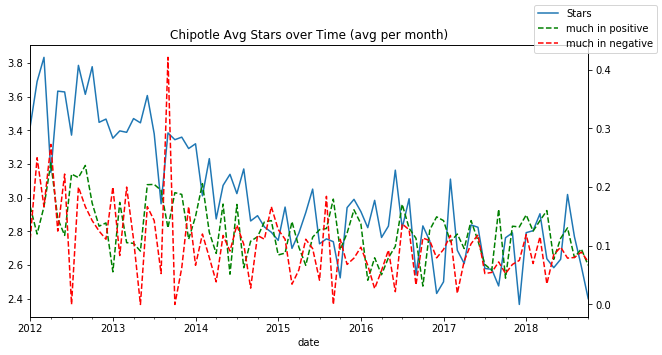

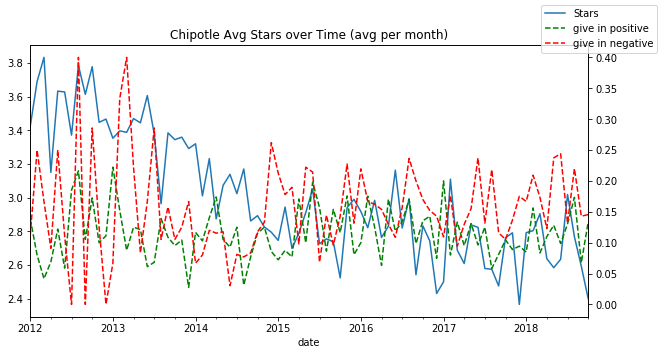

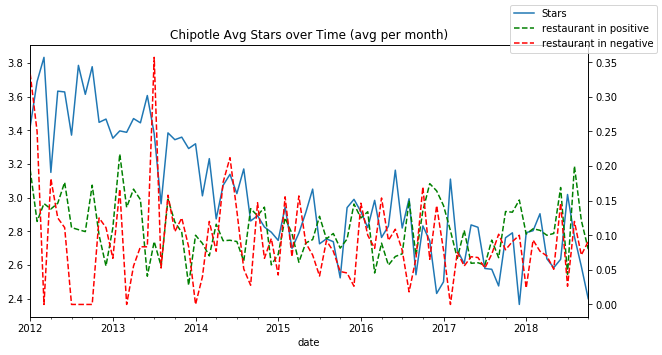

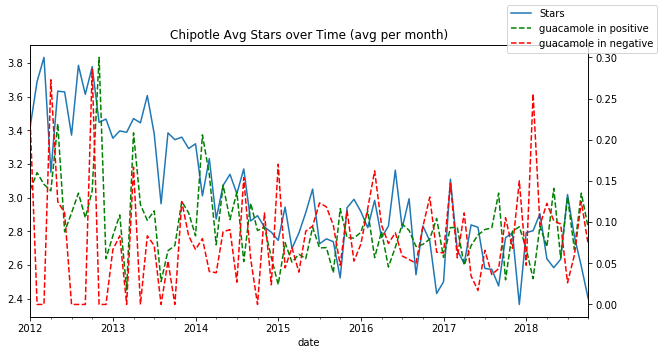

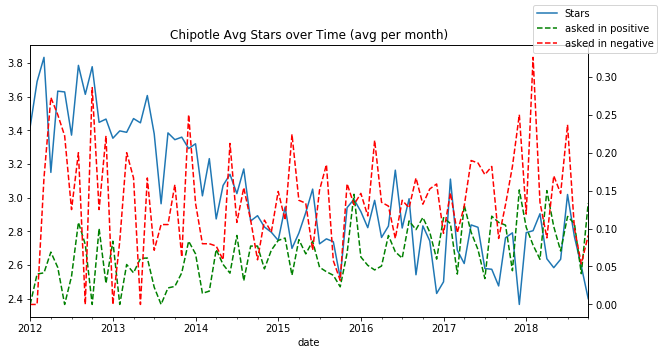

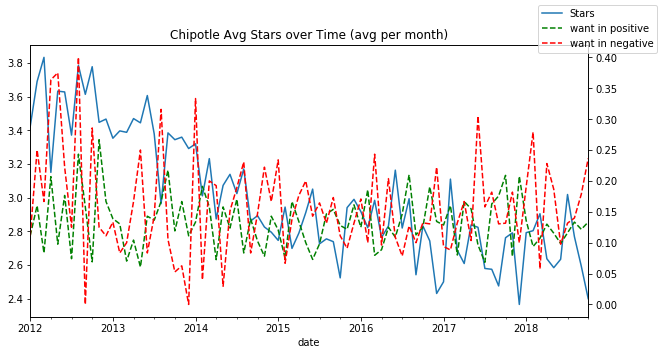

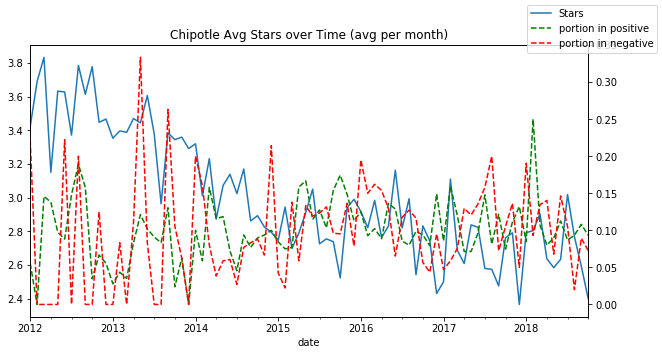

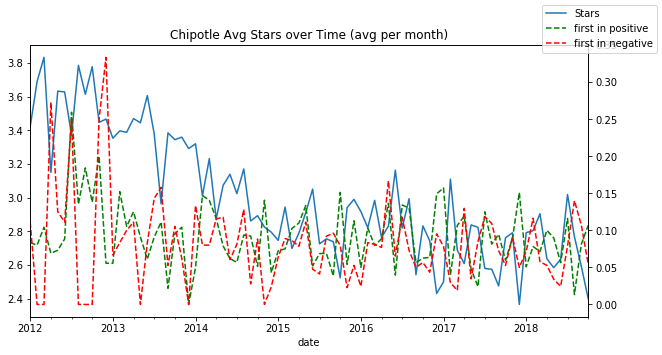

In [31]:
start_date = '2012-01-01'
end_date = '2018-10-31'

for woi in words:
    Chipotle_woi = Chipotle.loc[Chipotle['text'].str.contains(woi)]
    Chipotle_woi.head()
    Chipotle_woi_pos_cnt = Chipotle_woi.set_index('date').groupby('sentiment').get_group('positive').resample('M').count().sentiment
    Chipotle_woi_neg_cnt = Chipotle_woi.set_index('date').groupby('sentiment').get_group('negative').resample('M').count().sentiment

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    stars_plot = GetStarsInDateRange(ch_star_monthly_change, start_date, end_date, 'stars_y')
    stars_plot.plot.line(label='Stars', ax=ax, rot=0, figsize=(10, 5), title="Chipotle Avg Stars over Time (avg per month)", style='-')
    ax_r = ax.twinx()

    Chipotle_woi_pos_ratio = Chipotle_woi_pos_cnt.divide(Chipotle_pos_cnt, fill_value=0.0)
    Chipotle_woi_pos_ratio = Chipotle_woi_pos_ratio.dropna()
    woi_pos_ratio_plot = GetStarsInDateRange(Chipotle_woi_pos_ratio, start_date, end_date, 'sentiment')
    woi_pos_ratio_plot.plot.line(label='{} in positive'.format(woi), ax=ax_r, rot=0, style='g--')

    Chipotle_woi_neg_ratio = Chipotle_woi_neg_cnt.divide(Chipotle_neg_cnt, fill_value=0.0)
    Chipotle_woi_neg_ratio = Chipotle_woi_neg_ratio.dropna()
    woi_neg_ratio_plot = GetStarsInDateRange(Chipotle_woi_neg_ratio, start_date, end_date, 'sentiment')
    woi_neg_ratio_plot.plot.line(label='{} in negative'.format(woi), ax=ax_r, rot=0, style='r--')

    fig.legend()

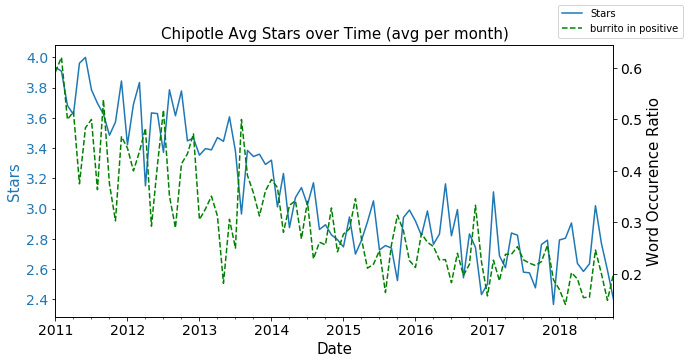

In [32]:
start_date = '2011-01-01'
end_date = '2018-10-31'

woi = "burrito"
Chipotle_woi = Chipotle.loc[Chipotle['text'].str.contains(woi)]
Chipotle_woi.head()
Chipotle_woi_pos_cnt = Chipotle_woi.set_index('date').groupby('sentiment').get_group('positive').resample('M').count().sentiment
Chipotle_woi_neg_cnt = Chipotle_woi.set_index('date').groupby('sentiment').get_group('negative').resample('M').count().sentiment

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
stars_plot = GetStarsInDateRange(ch_star_monthly_change, start_date, end_date, 'stars_y')
stars_plot.plot.line(label='Stars', ax=ax, rot=0, figsize=(10, 5), title="Chipotle Avg Stars over Time (avg per month)", style='-')
ax_r = ax.twinx()

Chipotle_woi_pos_ratio = Chipotle_woi_pos_cnt.divide(Chipotle_pos_cnt, fill_value=0.0)
Chipotle_woi_pos_ratio = Chipotle_woi_pos_ratio.dropna()
woi_pos_ratio_plot = GetStarsInDateRange(Chipotle_woi_pos_ratio, start_date, end_date, 'sentiment')
woi_pos_ratio_plot.plot.line(label='{} in positive'.format(woi), ax=ax_r, rot=0, style='g--')

ax.set_xlabel('Date', fontsize=15)
ax.set_ylabel('Stars', color='#1f77b4', fontsize=15)
ax.tick_params(axis='y', labelcolor='#1f77b4')
ax_r.set_ylabel('Word Occurence Ratio', fontsize=15)
ax.set_title("Chipotle Avg Stars over Time (avg per month)", fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=14)
ax_r.tick_params(axis='both', which='major', labelsize=14)

fig.legend()